In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# class TrialSolution(tf.keras.models.Model):
#   def __init__(self, conditions, n_i, n_h, n_o=1, activation='sigmoid', equation_type='ODE'):
#     super(TrialSolution, self).__init__()
#     self.n_i = n_i
#     self.n_h = n_h
#     self.n_o = n_o
#     self.conditions = conditions
#     self.hidden_layer = tf.keras.layers.Dense(units=self.n_h, activation=activation)
#     self.output_layer = tf.keras.layers.Dense(units=self.n_o, activation='linear')
    
#   def call(self, X):
#     X = tf.convert_to_tensor(X)
#     response = self.hidden_layer(X)
#     response = self.output_layer(response)
#     response *= tf.reshape(X, shape=resonse) ** 2 
#     response += tf.reshape(X, shape=response.shape) 
#     return response

In [3]:
class TrialSolution(tf.keras.models.Model):
  def __init__(self, conditions, n_i, n_h, n_o=1, activation='sigmoid', equation_type='ODE'):
    super(TrialSolution, self).__init__()
    self.n_i = n_i
    self.n_h = n_h
    self.n_o = n_o
    self.conditions = conditions
    self.hidden_layer = tf.keras.layers.Dense(units=self.n_h, activation=activation)
    self.output_layer = tf.keras.layers.Dense(units=self.n_o, activation='linear')
    
  def call(self, X):
    X = tf.convert_to_tensor(X)
    response = self.hidden_layer(X)
    response = self.output_layer(response)
    
    boundary_value = tf.constant(0., dtype='float64', shape=response.get_shape())
    
    for condition in self.conditions:
      vanishing = tf.constant(1., dtype='float64', shape=response.get_shape())
      temp_bc = 0
      if condition['type'] == 'dirichlet':
        temp_bc = tf.reshape(condition['function'](X), shape=boundary_value.shape)           
        for vanisher in self.conditions:
          if vanisher['variable'] != condition['variable'] and vanisher['value'] != condition['value']:
            if vanisher['type'] == 'dirichlet':
              vanishing *= (X[:, vanisher['variable']]
                                        - tf.constant(vanisher['value'], dtype='float64', shape=boundary_value.shape))
            elif vanisher['type'] == 'neumann':
              vanishing *= (X[:, vanisher['variable']]
                                        - tf.constant(vanisher['value'], dtype='float64', shape=boundary_value.shape))
        boundary_value += temp_bc * vanishing
        response *= (tf.constant(condition['value'], dtype='float64', shape=boundary_value.shape)
                     - tf.reshape(X[:, condition['variable']], shape=boundary_value.shape))
      elif condition['type'] == 'neumann':
        temp_bc = (tf.reshape(condition['function'](X), shape=boundary_value.shape)
                   * tf.reshape(X[:, condition['variable']], shape=boundary_value.shape))
        boundary_value = temp_bc
        response *= (tf.constant(condition['value'], dtype='float64', shape=boundary_value.shape)
                     - tf.reshape(X[:, condition['variable']], shape=boundary_value.shape))  
    response += boundary_value
    return response

In [4]:
inits = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: tf.constant(0., dtype='float64', shape=(X.shape[0],1))},
        {'variable':0, 'value':0, 'type':'neumann',
        'function':lambda X: tf.constant(1., dtype='float64', shape=(X.shape[0],1))}]

In [5]:
ts = TrialSolution(conditions=inits, n_i=1, n_h=10, n_o=1)

In [6]:
Xs = np.arange(0, 2, 0.2) + 1e-6
Xs = Xs.reshape(-1,1)

In [7]:
def diff_loss(network, inputs):
  with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
      inputs = tf.convert_to_tensor(inputs)
      tape.watch(inputs)
      tape2.watch(inputs)
      response = network(inputs)  
    grads = tape.gradient(response, inputs)
  laplace = tape2.gradient(grads, inputs)
  loss = tf.square(laplace + tf.constant(0.2, dtype='float64')*grads + response
          + tf.constant(0.2, dtype='float64')*tf.exp( tf.constant(-0.2, dtype='float64') * inputs)
                   * tf.cos(inputs))
  return loss

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
train_loss = tf.keras.metrics.Mean('train')

In [9]:
@tf.function
def train_step(X):
  with tf.GradientTape() as tape:
    loss = diff_loss(ts, X)
  gradients = tape.gradient(loss, ts.trainable_variables)
  optimizer.apply_gradients(zip(gradients, ts.trainable_variables))
  train_loss(loss)

In [10]:
ts(tf.convert_to_tensor(Xs))

<tf.Tensor: id=119, shape=(10, 1), dtype=float64, numpy=
array([[9.99999801e-07],
       [1.90635686e-01],
       [3.57003491e-01],
       [4.90995577e-01],
       [5.84923907e-01],
       [6.31695947e-01],
       [6.24951289e-01],
       [5.59154535e-01],
       [4.29643173e-01],
       [2.32633157e-01]])>

0.02770484


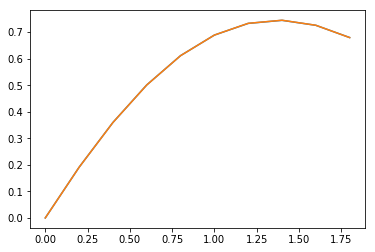

0.013857794


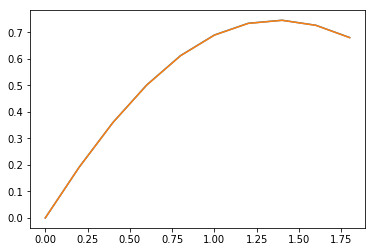

0.009917281


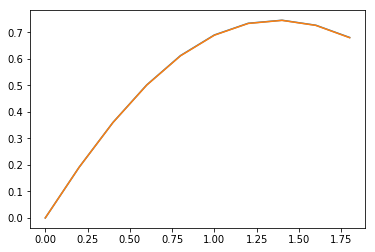

0.007719096


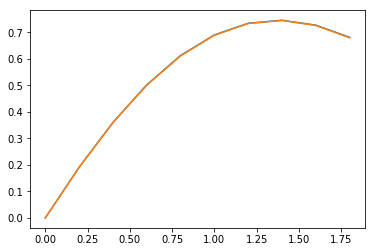

0.0063569923


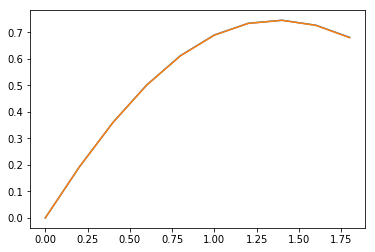

0.0053860946


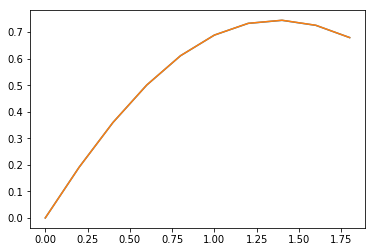

0.0046825013


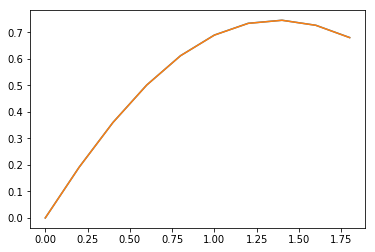

0.0041496083


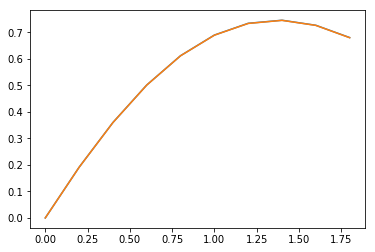

0.003775892


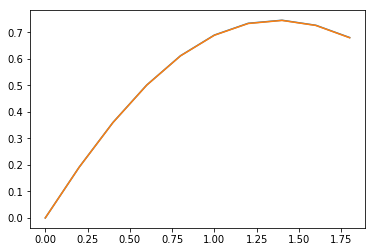

0.0034722725


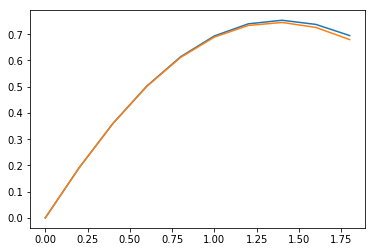

0.003189963


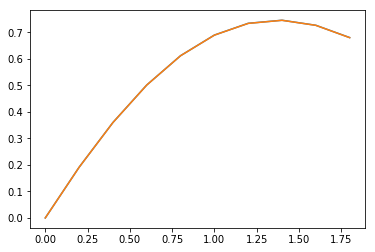

0.0029789489


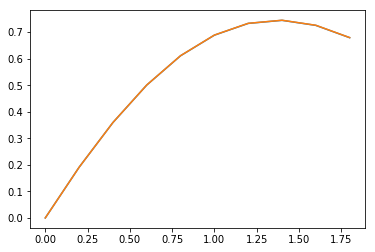

0.0027898292


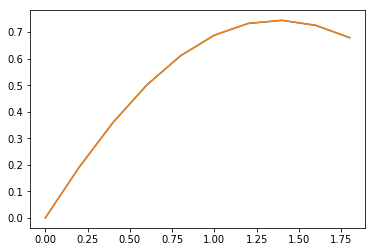

0.0026349246


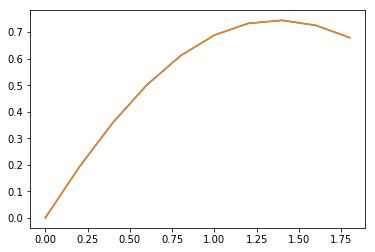

0.0024917668


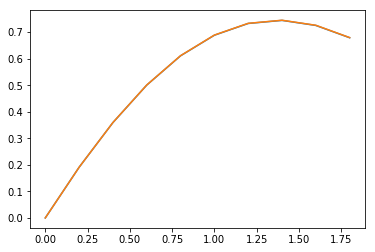

0.0023675887


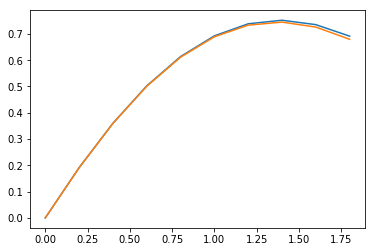

0.0022614386


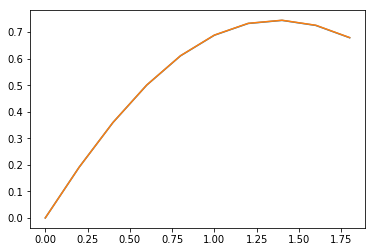

0.00216864


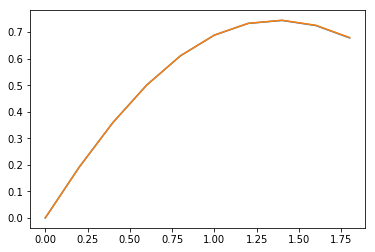

0.0020816324


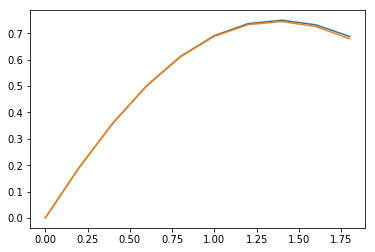

0.002003736


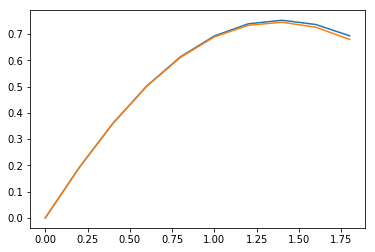

0.0019315801


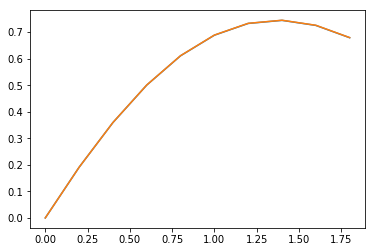

0.0018680904


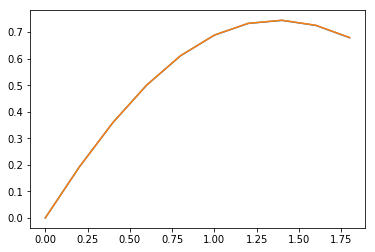

0.0018078854


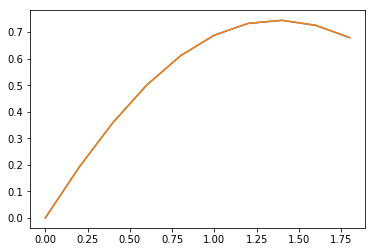

0.0017532153


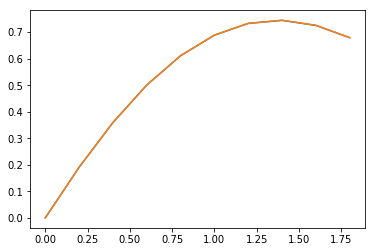

0.0017035828


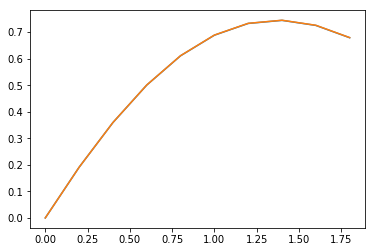

0.0016599926


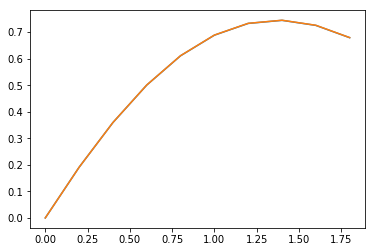

0.0016188031


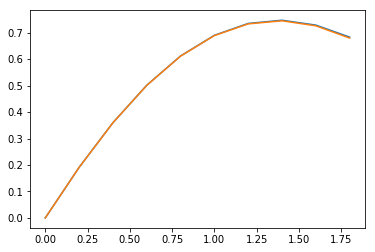

0.0015797346


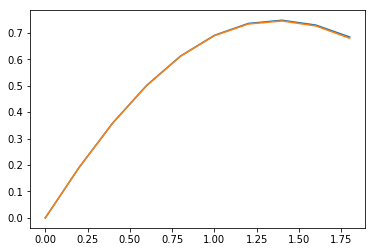

0.0015428596


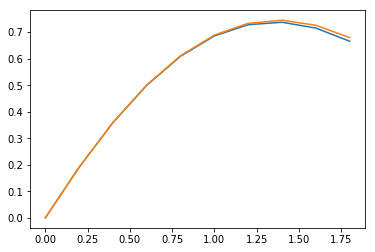

0.0015073728


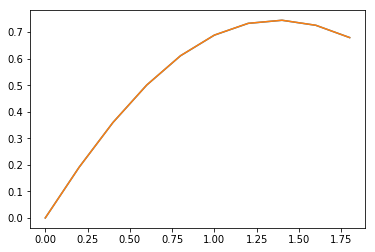

0.0014746825


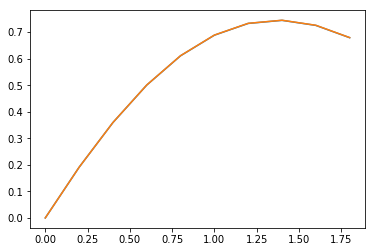

0.0014443761


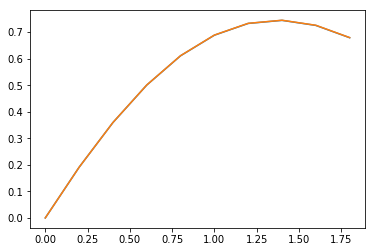

0.001415627


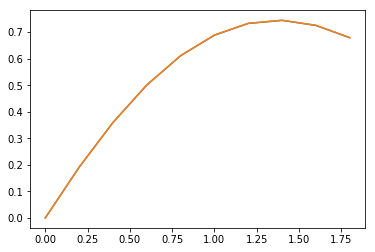

0.0013904264


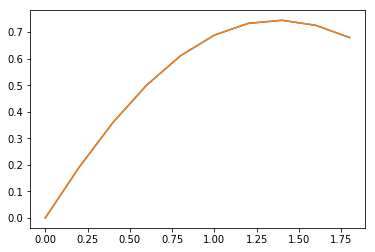

0.0013651935


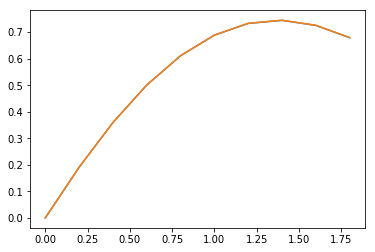

0.0013423658


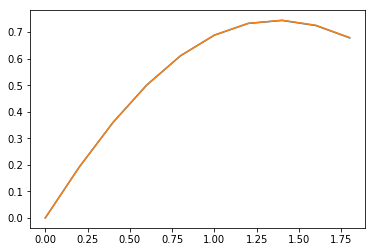

0.0013184181


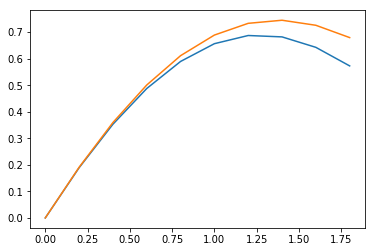

0.0012977269


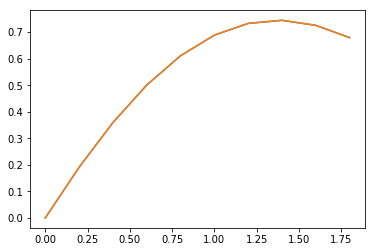

0.0012766066


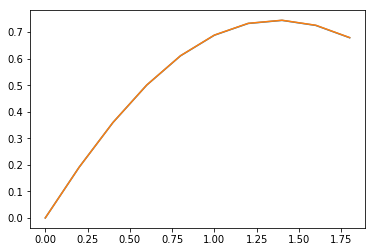

0.0012602763


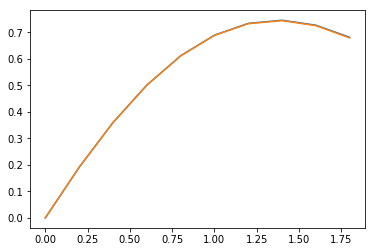

0.0012397552


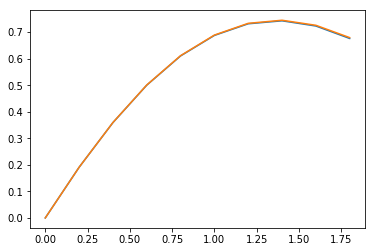

0.0012225377


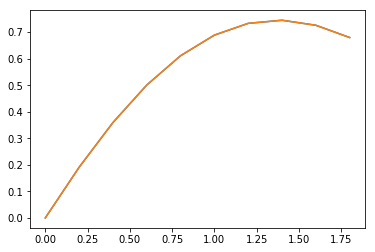

0.0012078645


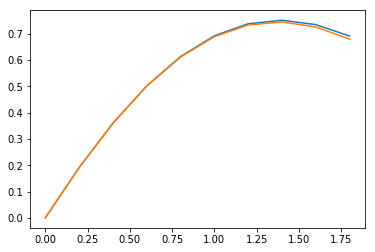

0.0011923877


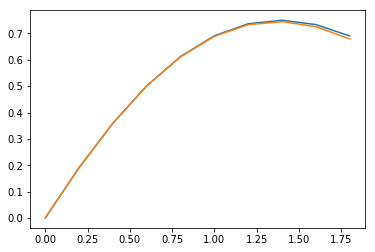

0.0011770495


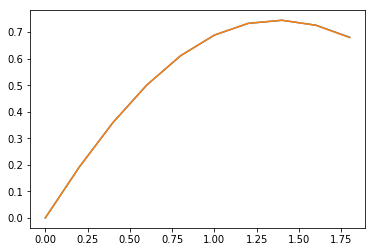

0.0011619959


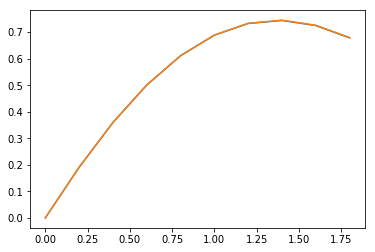

0.0011481781


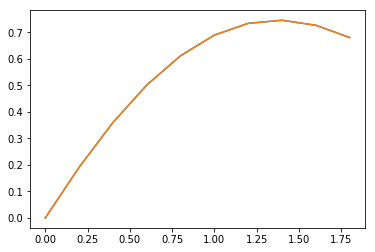

0.0011349177


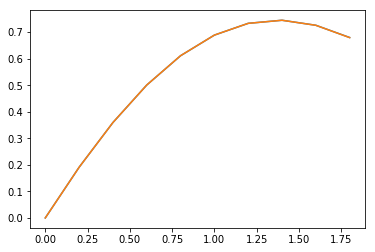

0.0011225783


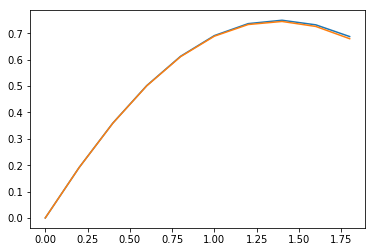

0.0011090358


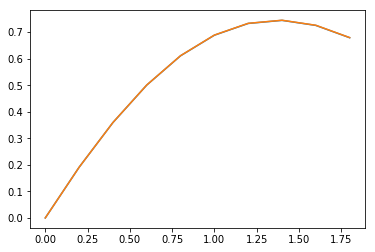

0.0010975106


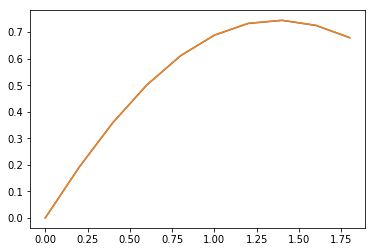

0.0010855207


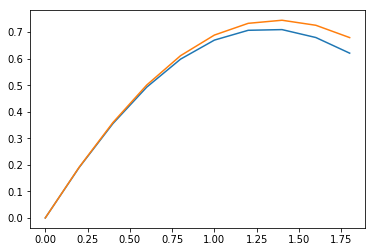

0.0010748958


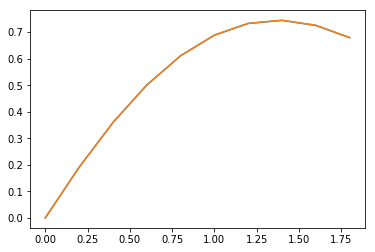

0.0010646821


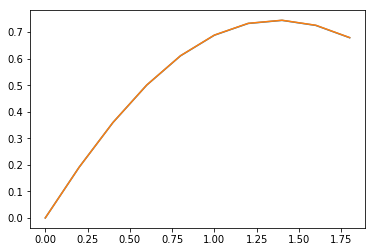

0.0010555858


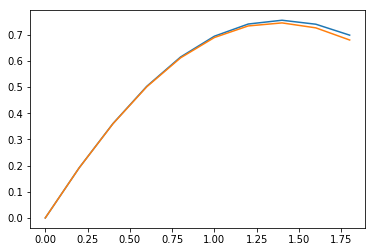

0.001045954


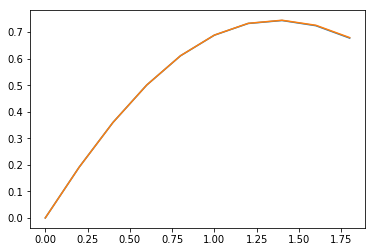

0.0010353043


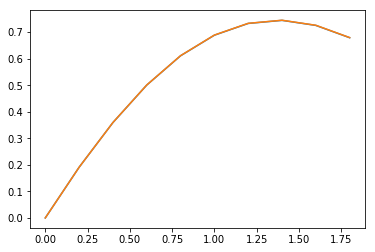

0.001026345


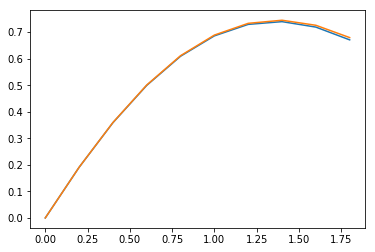

0.0010187707


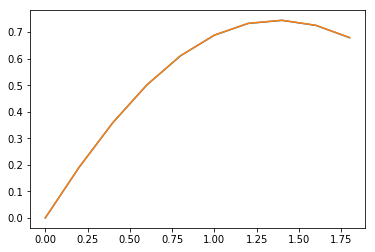

0.001010489


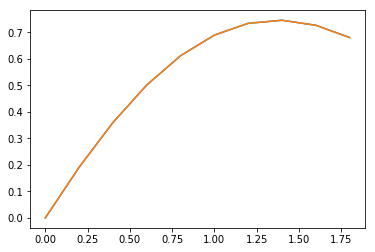

0.0010024953


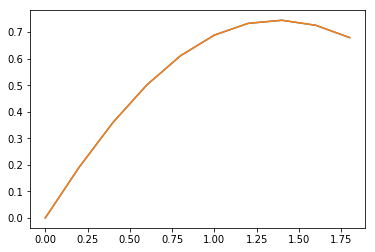

0.000994921


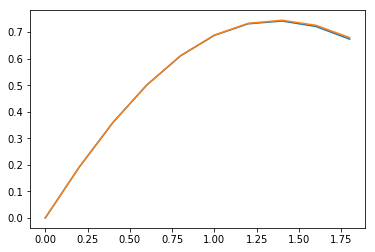

0.0009871057


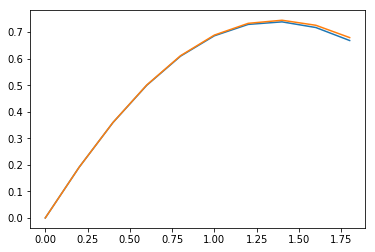

0.0009790611


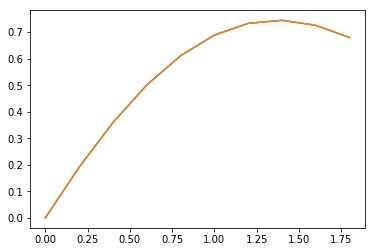

0.0009710382


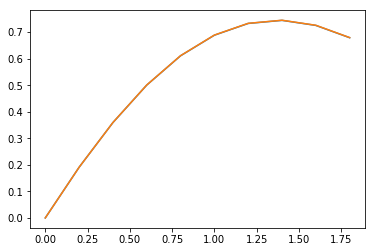

0.00096464576


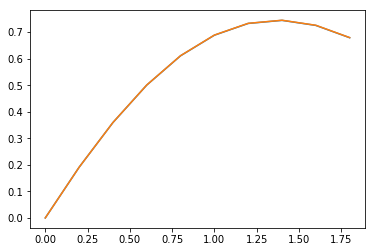

0.0009587156


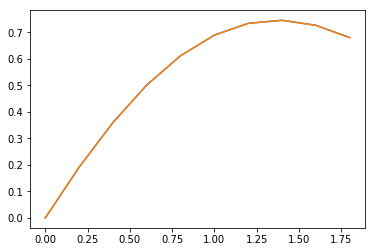

0.000951173


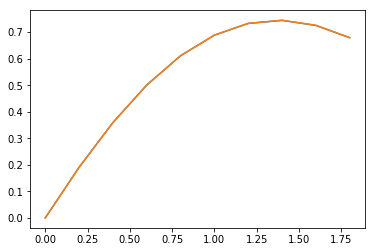

0.0009454391


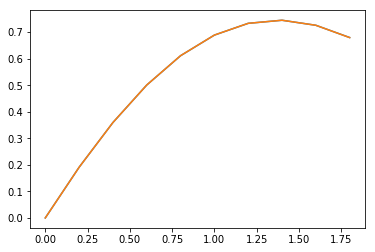

0.00093909894


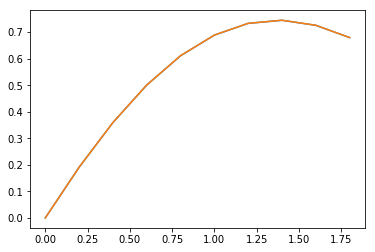

0.000932967


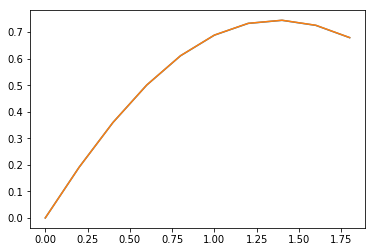

0.00092696346


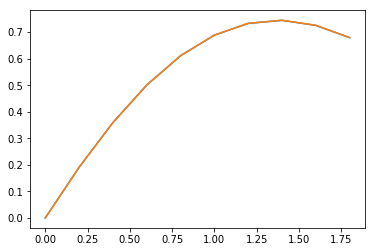

0.00092118816


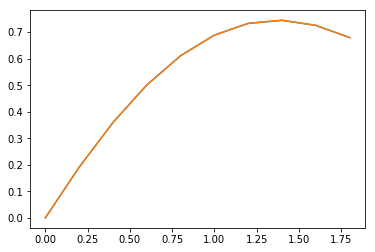

0.0009157465


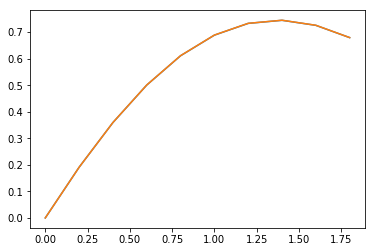

0.00091071276


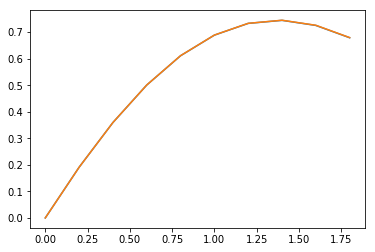

0.00090572896


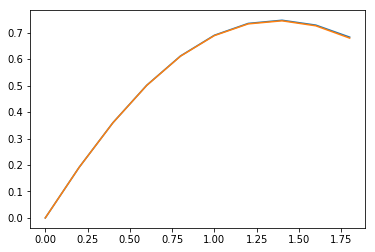

0.0008992252


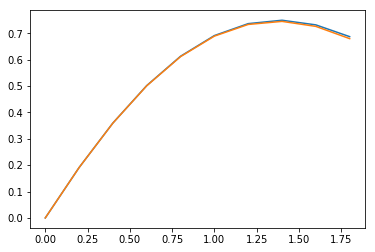

0.0008942625


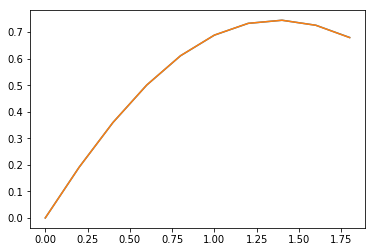

0.00088994985


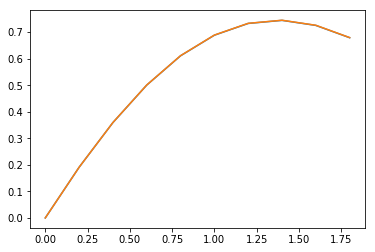

0.000885453


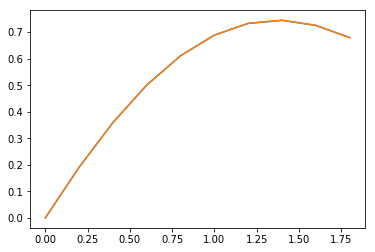

0.00088136137


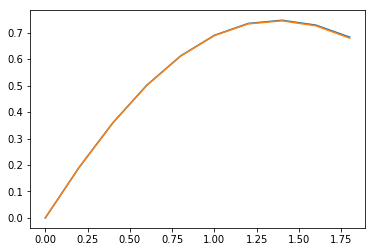

0.00087676034


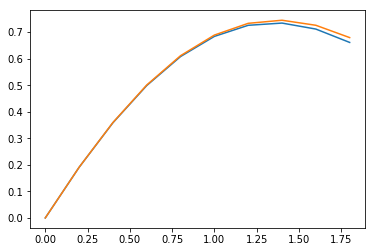

0.0008723967


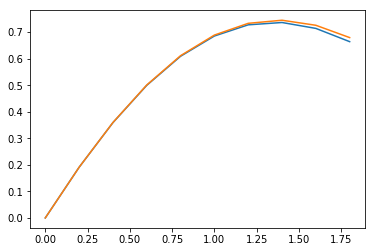

0.00086805684


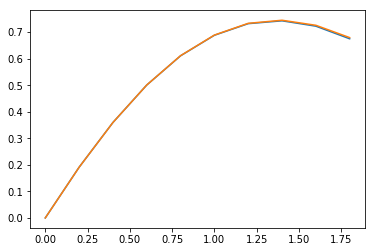

0.0008636498


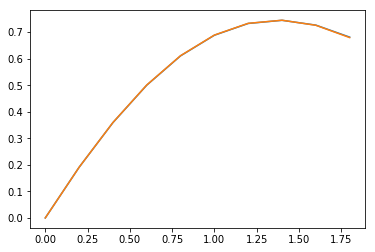

0.0008593526


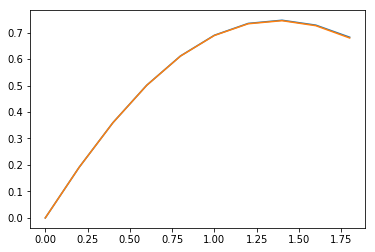

0.00085468567


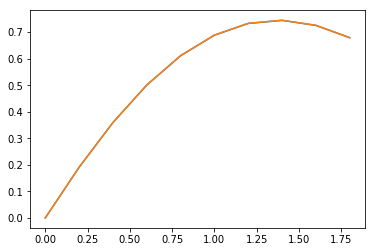

0.0008514643


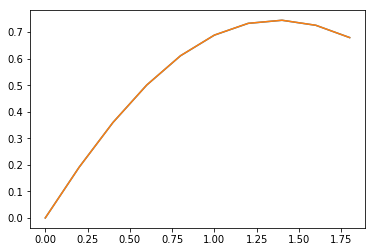

0.00084773224


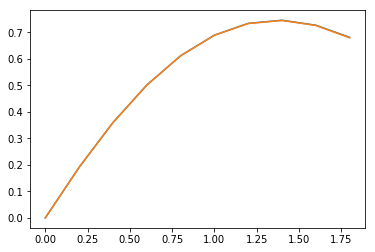

0.0008438569


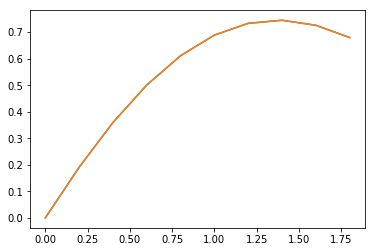

0.0008403397


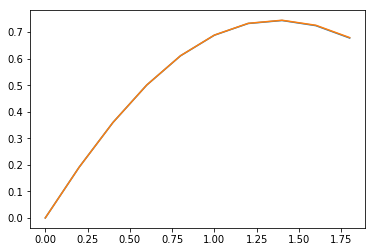

0.0008364625


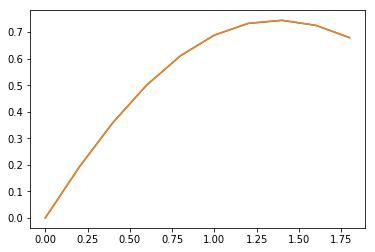

0.00083250285


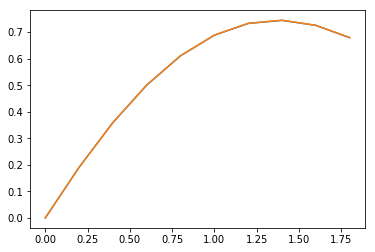

0.0008289193


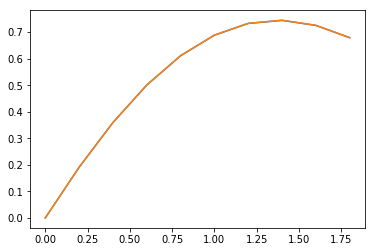

0.00082628476


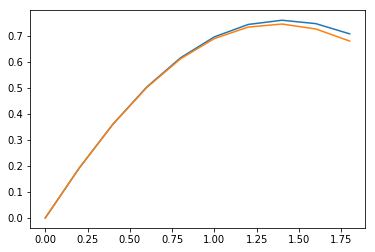

0.00082290807


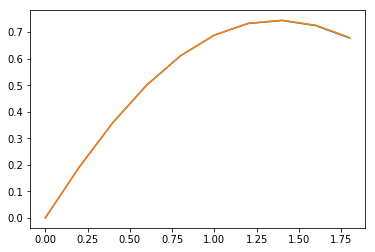

0.00081973005


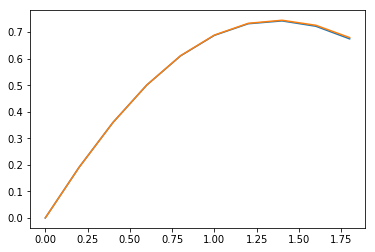

0.00081653474


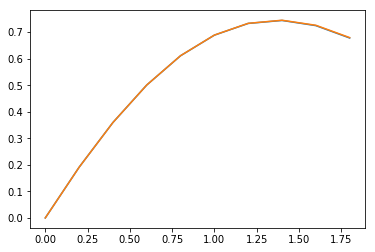

0.00081310817


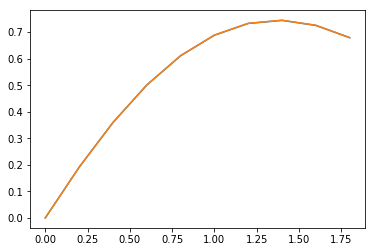

0.0008096692


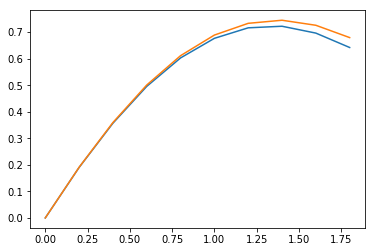

In [11]:
EPOCHS = 100000
for epoch in range(EPOCHS):
  train_step(Xs)
  if (epoch+1) % int(EPOCHS/10) == 0:
    print(train_loss.result().numpy())
    pred = ts.call(tf.convert_to_tensor(Xs, dtype='float64')).numpy()
    plt.plot(Xs, pred)
    plt.plot(Xs, np.exp(-0.2*Xs)*np.sin(Xs))
    plt.show()

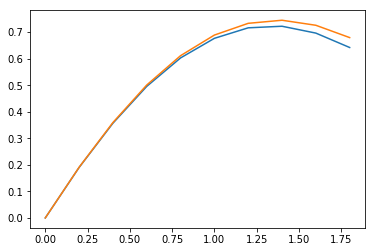

In [12]:
pred = ts(tf.convert_to_tensor(Xs, dtype='float64')).numpy()
plt.plot(Xs, pred)
plt.plot(Xs, np.exp(-0.2*Xs)*np.sin(Xs))
plt.show()

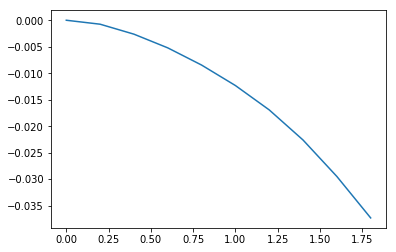

In [13]:
plt.plot(Xs, pred - np.exp(-0.2*Xs)*np.sin(Xs))
plt.show()